In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Data prep

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np

data_folder_path = Path("./gdrive/MyDrive/MO436---Twitter-bot-detection")
new_format_data_path = Path("./gdrive/MyDrive/MO436---Twitter-bot-detection/data/Twibot-20-new-format/")


file_path_mean = './gdrive/My Drive/MO436---Twitter-bot-detection/BERT_output/Tweets_mean_embedding.parquet'
df_tweets_mean = pd.read_parquet(file_path_mean)

In [3]:
# ! mkdir -p "./gdrive/MyDrive/Colab Notebooks/MO436/data/Twibot-20-old-format/"

In [4]:
# !unzip "./gdrive/MyDrive/Colab Notebooks/MO436/data/ETL_Twi20.zip" -d "./gdrive/MyDrive/Colab Notebooks/MO436/data/Twibot-20-old-format/"

In [5]:
neighbor_data_file = "edge.csv"
label_data_file = "label.csv"
profile_data_file = "node.part0.parquet"
# tweets_data_file = "Twi20_tweets.parquet"
split_data_file = "split.csv"

In [6]:
# domain_df = pd.read_parquet(old_format_data_path/domain_data_file)
neighbor_df = pd.read_csv(new_format_data_path/neighbor_data_file)
label_df = pd.read_csv(new_format_data_path/label_data_file)
profile_df = pd.read_parquet(new_format_data_path/profile_data_file)
split_df = pd.read_csv(new_format_data_path/split_data_file)

In [7]:
def profile_data_preprocessing(profile_df, label_df, split_df, neighbor_df):
    """
    Preprocess profile data by merging with label, split, and neighbor data,
    extracting public metrics, and calculating derived metrics.

    Parameters:
    - profile_df: DataFrame containing the profile data.
    - label_df: DataFrame containing labels for the profiles.
    - split_df: DataFrame containing split information.
    - neighbor_df: DataFrame containing neighbor relationships.

    Returns:
    - A DataFrame with preprocessed data.
    """

    # Cria um DataFrame que contém listas de IDs que uma fonte específica segue ou é amiga.
    follow_df = (
        neighbor_df
        # Filtra para relações 'follow' ou 'friend'.
        [lambda d: d["relation"].isin(["follow", "friend"])]
        # Agrupa por 'source_id' e 'relation' e coleta os 'target_id' em listas.
        .groupby(["source_id", "relation"])["target_id"]
        .apply(list)
        .to_frame()  # Converte a série em um DataFrame.
        .reset_index()  # Reseta o índice para tornar 'source_id' e 'relation' em colunas.
        # Usa pivot para transformar as relações em colunas separadas por 'source_id'.
        .pivot(values="target_id", index="source_id", columns="relation")
        .reset_index()  # Reseta o índice para manter 'source_id' como coluna.
        .rename(columns={"source_id": "id"})  # Renomeia 'source_id' para 'id'.
    )

    # Cria um DataFrame que contém listas de IDs que seguem um alvo específico.
    followed_df = (
        neighbor_df
        # Filtra para relações 'follow'.
        [lambda d: d["relation"].isin(["follow"])]
        # Agrupa por 'target_id' e coleta os 'source_id' em listas.
        .groupby(["target_id"])["source_id"]
        .apply(list)
        .to_frame()  # Converte a série em um DataFrame.
        .reset_index()  # Reseta o índice para tornar 'target_id' em uma coluna.
        # Renomeia 'target_id' para 'id' e 'follow' para 'followed'.
        .rename(columns={"target_id": "id", "source_id": "followed"})
    )

    # Retorna um DataFrame combinado e enriquecido.
    return (
        profile_df
        # Junta com 'label_df', 'split_df', 'follow_df', e 'followed_df' baseado em 'id'.
        .merge(label_df, on="id", how="left")
        .merge(split_df, on="id", how="left")
        .merge(follow_df, on="id", how="left")
        .merge(followed_df, on="id", how="left")
        # Cria novas colunas ou modifica as existentes.
        .assign(
            # Converte 'created_at' para datetime.
            created_at=lambda d: pd.to_datetime(d["created_at"]),
            # Extrai contagens de seguidores de 'public_metrics'.
            followers_count=lambda d: d.public_metrics.str["followers_count"],
            # Extrai contagens de seguidos de 'public_metrics'.
            following_count=lambda d: d.public_metrics.str["following_count"],
            # Calcula a proporção de seguidores por seguidos.
            followers_follow_proportion=lambda d: d["followers_count"] / (d["following_count"] + 1e-3),
            # Extrai a contagem de listas de 'public_metrics'.
            listed_count=lambda d: d.public_metrics.str["listed_count"],
            # Extrai a contagem de tweets de 'public_metrics'.
            tweet_count=lambda d: d.public_metrics.str["tweet_count"],
            # Determina a data de referência (a data mais recente de 'created_at').
            reference_date=lambda d: d["created_at"].max(),
            # Calcula 'tenure' como o número de dias desde 'created_at'.
            tenure=lambda d: (d["reference_date"] - d["created_at"]).dt.days,
            # Cria uma string com IDs de quem a fonte segue.
            follow_string=lambda d: d["follow"].str.join(" ").fillna(""),
            # Cria uma string com IDs de quem segue a fonte.
            followed_string=lambda d: d["followed"].str.join(" ").fillna(""),
            # Cria uma string com IDs de amigos.
            friend_string=lambda d: d["friend"].str.join(" ").fillna(""),
            # Gera um número aleatório para cada linha.
            random_number=lambda d: np.random.random(len(d))
        )
    )

In [8]:
preprocessed_profile_df = (
    profile_df
    .pipe(
        profile_data_preprocessing,
        label_df=label_df, split_df=split_df, neighbor_df=neighbor_df
      )
  )

In [9]:
preprocessed_profile_df.followers_follow_proportion

0         22181.465056
1             0.000000
2          1605.973461
3            68.233062
4            20.593477
              ...     
229575        0.080617
229576        1.129729
229577        0.164541
229578        0.247309
229579        0.368224
Name: followers_follow_proportion, Length: 229580, dtype: float64

In [25]:
preprocessed_profile_df['friend_string']

0                                                          
1         u170861207 u23970102 u47293791 u29458079 u1799...
2         u46464108 u21536398 u18643437 u589490020 u1363...
3         u2324715174 u24030137 u2336676015 u192684124 u...
4         u1628313708 u726405625 u130868956 u26652768 u3...
                                ...                        
229575                                                     
229576                                                     
229577                                                     
229578                                                     
229579                                                     
Name: friend_string, Length: 229580, dtype: object

# Graph Feature Engineering

 ***CountVectorizer*** - ferramenta fornecida do scikit-learn que converte texto em uma matriz de contagens de tokens, também conhecida como *bag of words*. Aqui está como ele funciona:

- Tokenização: Divide o texto em palavras, ou "tokens", usando um padrão de expressão regular que, por padrão, corresponde a palavras de 2 ou mais caracteres alfanuméricos (letras e números).

- Normalização (opcional): Por padrão, todos os tokens são convertidos em minúsculas para que palavras como "Hello" e "hello" sejam consideradas o mesmo token. Você também pode especificar um parâmetro para realizar outras formas de normalização.

- Contagem: Conta quantas vezes cada token ocorre em cada documento.

- Construção de Matriz: *Constrói uma matriz* onde as *linhas representam documentos* e as *colunas representam tokens*. Cada célula da matriz contém a contagem da frequência de um token específico em um documento específico.

***Bag of Words (BoW)*** é um modelo usado no processamento de linguagem natural e recuperação de informações.

- Neste modelo, um texto é representado como um multiconjunto de suas palavras, desconsiderando a gramática e até a ordem das palavras, mas mantendo a multiplicidade. Em essência, é uma forma de representar texto como um conjunto de palavras independentes.

Como funciona o BoW:

- Vocabulário: Primeiro, um vocabulário de palavras conhecidas é construído a partir de um conjunto de documentos. Cada palavra única em todo o conjunto de documentos forma o vocabulário.

- Representação de Documentos: Em seguida, cada documento é representado por um vetor com a mesma dimensão que o vocabulário. Cada elemento do vetor corresponde a uma palavra do vocabulário e é preenchido com a contagem daquela palavra no documento.

--------------------------------------------------------------------------------
Exemplo: suponha que temos um vocabulário formado pelas palavras {gato, cachorro, late, mia}, e dois documentos:

1. Documento 1: "o gato mia"
2. Documento 2: "o cachorro late e o gato mia"<br>
Cada documento seria representado por um vetor de 4 dimensões (correspondendo ao número de palavras no vocabulário)

- Vetor para Documento 1: [1, 0, 0, 1] <br>
(gato aparece uma vez, cachorro não aparece, late não aparece, mia aparece uma vez)
- Vetor para Documento 2: [1, 1, 1, 1] <br>
(gato aparece uma vez, cachorro aparece uma vez, late aparece uma vez, mia aparece uma vez)
--------------------------------------------------------------------------------
*Vantagens do BoW:*

- Simplicidade: Fácil de entender e implementar.
- Eficiência: Pode ser muito eficiente para análises em grandes conjuntos de dados.

*Desvantagens do BoW:*

- Perda de Contexto: Informações sobre a ordem das palavras e a gramática são perdidas, o que pode ser crucial para entender o significado de um texto.
- Esparsidade: O vetor resultante pode ser muito grande e majoritariamente preenchido com zeros, especialmente se o vocabulário for grande.
- Sensibilidade a Palavras Não Frequentes: Palavras raras podem distorcer a representação.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
# def feature_selection_pipeline(features_df):
#   #use recursive shap error contribution
#   return

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

ndims = 10
feature_eng_pipeline = ColumnTransformer(
    [
        ("vectorizer_followed", make_pipeline(CountVectorizer()), "followed_string"),
        ("vectorizer_follow", make_pipeline(CountVectorizer()), "follow_string"),
        ("vectorizer_friend", make_pipeline(CountVectorizer()), "friend_string")
    ]
)

feature_eng_pipeline = make_pipeline(feature_eng_pipeline, TruncatedSVD(3*ndims))
# feature_eng_pipeline = make_pipeline(feature_eng_pipeline, TruncatedSVD(50))

# inference_pipeline = make_pipeline(feature_eng_pipeline, SGDClassifier(loss = "log"))
# CountVectorizer().fit_transform(preprocessed_profile_df["follow_string"].values)

In [28]:
ndims = 30  # Um número alto para não truncar prematuramente

# Primeira etapa: transformação do texto
vectorizer = CountVectorizer()
X_transformed = vectorizer.fit_transform(preprocessed_profile_df['friend_string'])

# Segunda etapa: SVD sem truncar
svd = TruncatedSVD(n_components=ndims)
X_svd = svd.fit_transform(X_transformed)

# Verifique a variância explicada acumulada
variancia_explicada = np.cumsum(svd.explained_variance_ratio_)

# Encontre o número de componentes para a variância desejada, por exemplo, 0.95
n_componentes = np.where(variancia_explicada >= 0.95)[0][0]
n_componentes


IndexError: ignored

In [30]:
preprocessed_profile_df['friend_string']

0                                                          
1         u170861207 u23970102 u47293791 u29458079 u1799...
2         u46464108 u21536398 u18643437 u589490020 u1363...
3         u2324715174 u24030137 u2336676015 u192684124 u...
4         u1628313708 u726405625 u130868956 u26652768 u3...
                                ...                        
229575                                                     
229576                                                     
229577                                                     
229578                                                     
229579                                                     
Name: friend_string, Length: 229580, dtype: object

In [29]:
X_transformed

<229580x99059 sparse matrix of type '<class 'numpy.int64'>'
	with 117110 stored elements in Compressed Sparse Row format>

In [27]:
variancia_explicada

array([0.00126317, 0.00227846, 0.00315006, 0.00393101, 0.00460296,
       0.00518211, 0.0057394 , 0.00628737, 0.00681619, 0.0073298 ,
       0.00783318, 0.00831391, 0.00878378, 0.00924616, 0.00969261,
       0.0101292 , 0.01054609, 0.01096045, 0.01137182, 0.01177952,
       0.01217415, 0.01256264, 0.01294865, 0.01332923, 0.0137024 ,
       0.01407198, 0.01443712, 0.01479496, 0.0151468 , 0.01549573,
       0.01583958, 0.01618129, 0.01651804, 0.01684958, 0.01717762,
       0.01750254, 0.01782315, 0.01813714, 0.01844855, 0.0187588 ,
       0.01906787, 0.01937434, 0.01967711, 0.01997956, 0.02027806,
       0.02057233, 0.02086599, 0.0211561 , 0.02144427, 0.02172756,
       0.02200904, 0.02228894, 0.02256681, 0.02284429, 0.02311912,
       0.02339265, 0.02366359, 0.02393376, 0.02419858, 0.02446276,
       0.02472537, 0.02498745, 0.02524726, 0.02550507, 0.02576198,
       0.0260158 , 0.02626827, 0.02652021, 0.02676908, 0.02701508,
       0.02725896, 0.02750178, 0.02774373, 0.02798343, 0.02822

In [13]:
preprocessed_profile_df = pd.read_parquet(data_folder_path.parent/"preprocessed_features_with_graph_embeddings.parquet")

In [14]:
train_mask = lambda d: d["split"] == "train"
test_mask = lambda d: d["split"] == "test"
support_mask = lambda d: d["split"] == "support"
val_mask = lambda d: d["split"] == "val"

target = "label"

preprocessed_profile_df.label.value_counts()

bot      6589
human    5237
Name: label, dtype: int64

In [15]:
lambda d: (train_mask(d) | support_mask(d))

<function __main__.<lambda>(d)>

In [16]:
feature_eng_pipeline.fit(preprocessed_profile_df[lambda d: (train_mask(d) | support_mask(d))])


# X = feature_eng_pipeline.transform(preprocessed_profile_df)
# y = preprocessed_profile_df[target]


graph_embs = feature_eng_pipeline.transform(preprocessed_profile_df)
embs_names = (
    [f"followed_embs{i}" for i in range(ndims)] +
    [f"follow_embs{i}" for i in range(ndims)] +
    [f"friend_embs{i}" for i in range(ndims)]
  )

preprocessed_profile_df[embs_names] = graph_embs

del graph_embs


# y_train = preprocessed_profile_df[train_mask][target]

# X_val = feature_eng_pipeline.transform(preprocessed_profile_df[val_mask])
# y_val = preprocessed_profile_df[val_mask][target]

# X_test = feature_eng_pipeline.transform(preprocessed_profile_df[test_mask])
# y_test = preprocessed_profile_df[test_mask][target]

# preprocessed_profile_df.split.value_counts()

# preprocessed_profile_df[lambda d: d.split == "support"]

In [17]:
preprocessed_profile_df.to_parquet(new_format_data_path.parent/"preprocessed_features_with_graph_embeddings.parquet")

In [24]:
df = preprocessed_profile_df
df.columns

Index(['created_at', 'description', 'entities', 'id', 'location', 'name',
       'pinned_tweet_id', 'profile_image_url', 'protected', 'public_metrics',
       'url', 'username', 'verified', 'withheld', 'label', 'split', 'follow',
       'friend', 'followed', 'followers_count', 'following_count',
       'followers_follow_proportion', 'listed_count', 'tweet_count',
       'reference_date', 'tenure', 'follow_string', 'followed_string',
       'friend_string', 'random_number', 'followed_embs0', 'followed_embs1',
       'followed_embs2', 'followed_embs3', 'followed_embs4', 'followed_embs5',
       'followed_embs6', 'followed_embs7', 'followed_embs8', 'followed_embs9',
       'follow_embs0', 'follow_embs1', 'follow_embs2', 'follow_embs3',
       'follow_embs4', 'follow_embs5', 'follow_embs6', 'follow_embs7',
       'follow_embs8', 'follow_embs9', 'friend_embs0', 'friend_embs1',
       'friend_embs2', 'friend_embs3', 'friend_embs4', 'friend_embs5',
       'friend_embs6', 'friend_embs7', 'frie

# Modelling

In [19]:
from lightgbm import LGBMClassifier

In [20]:
# model = LogisticRegression()
model = LGBMClassifier(n_estimators = 200, n_jobs = -1, learning_rate = 0.01)
model.fit(df[train_mask][embs_names], df[train_mask][target], eval_set = [(df[val_mask][embs_names], df[val_mask][target])])

[LightGBM] [Info] Number of positive: 3632, number of negative: 4646
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.438753 -> initscore=-0.246223
[LightGBM] [Info] Start training from score -0.246223


LGBMClassifier(learning_rate=0.01, n_estimators=200, n_jobs=-1)

In [21]:
df["prediction"] = model.predict_proba(df[embs_names])[:,1]

In [22]:
from sklearn.metrics import roc_auc_score

train_auc = roc_auc_score(df[train_mask][target], df[train_mask]["prediction"])
val_auc = roc_auc_score(df[val_mask][target], df[val_mask]["prediction"])
test_auc = roc_auc_score(df[test_mask][target], df[test_mask]["prediction"])

In [23]:
(train_auc, val_auc, test_auc)

(0.8610211450899927, 0.6191553462746407, 0.574330973756906)

In [ ]:
# !pip install pacmap
!pip install umap_learn -q

In [ ]:
# import pacmap
import umap
import matplotlib.pyplot as plt

# embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0)
embedding = umap.UMAP()

sample_df = df.sample(10_000)
# fit the data (The index of transformed data corresponds to the index of the original data)
embs = embedding.fit_transform(sample_df[embs_names])

sample_df[["umap0","umap1"]] = embs



<Axes: xlabel='umap0', ylabel='umap1'>

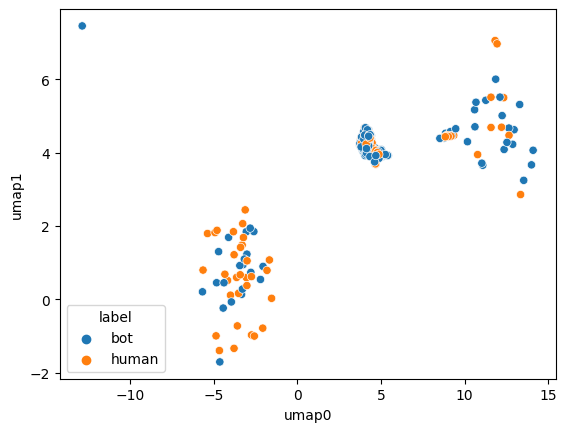

In [ ]:
# visualize the embedding
sns.scatterplot(data=sample_df, x="umap0", y="umap1", hue = "label")

<Axes: xlabel='umap0', ylabel='umap1'>

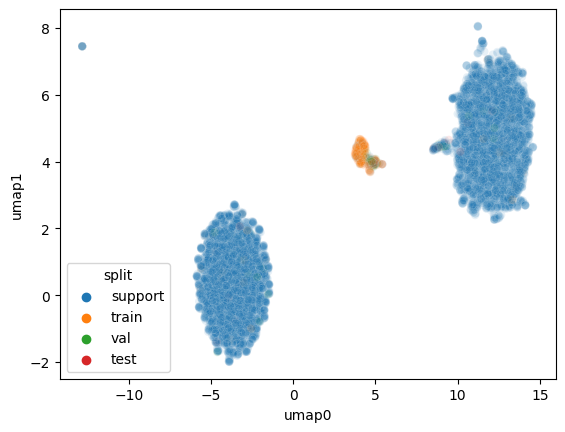

In [ ]:
sns.scatterplot(data=sample_df, x="umap0", y="umap1", hue = "split", alpha = 0.1)

<Axes: xlabel='umap0', ylabel='umap1'>

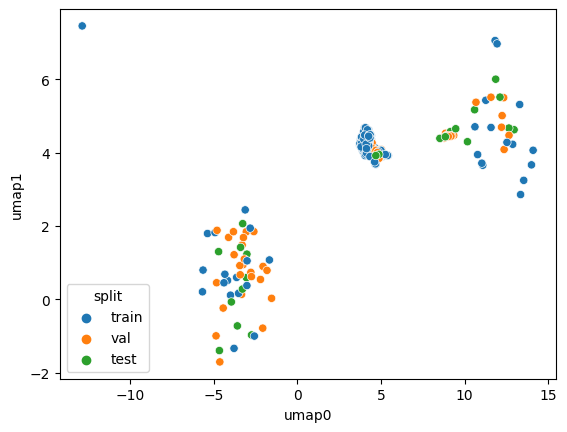

In [ ]:
sns.scatterplot(data=sample_df[lambda d: d.split != "support"], x="umap0", y="umap1", hue = "split")

# Evaluate distributional shift

# Feature Selection

In [ ]:
shap_values = model.predict(X_train, pred_contrib=True)
raw_preds = model.predict(X_train, raw_score=True)

shap_values_val = model.predict(X_val, pred_contrib=True)
raw_preds_val = model.predict(X_val, raw_score=True)

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=10. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=10. Current value: min_data_in_leaf=10


In [ ]:
score_without_feature = pd.DataFrame(raw_preds.reshape(-1,1) - shap_values)
score_without_feature_val = pd.DataFrame(raw_preds_val.reshape(-1,1) - shap_values_val)

In [ ]:
auc = roc_auc_score(preprocessed_profile_df[train_mask][target], raw_preds)

error_contrib = score_without_feature.apply(
    lambda d: roc_auc_score(preprocessed_profile_df[train_mask][target], d)
  ) - auc

auc = roc_auc_score(preprocessed_profile_df[val_mask][target], raw_preds_val)

error_contrib_val = score_without_feature_val.apply(lambda d: roc_auc_score(preprocessed_profile_df[val_mask][target], d)) - auc

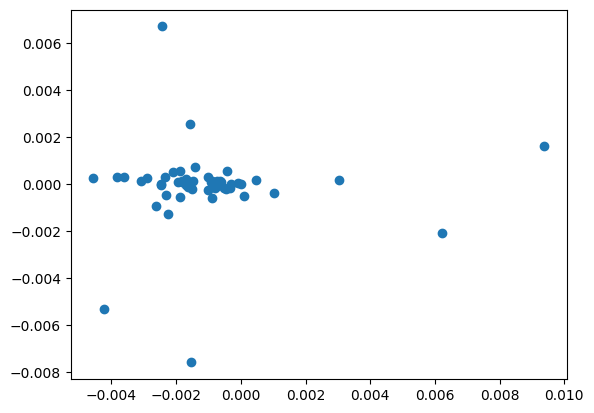

In [ ]:
plt.scatter(error_contrib, error_contrib_val)

## Code

In [ ]:
!pip install shap -q

In [ ]:
from toolz import curry

@curry
def fast_metric_with_ci_(data, *, n_samples=100, ci_level=0.95,
                     prediction='prediction', target='target', weight='weight', metric_fn = roc_auc_score):

    data = data.assign(weight=lambda df: df[weight] if weight is not None else 1)

    summary = (
        data
        .assign(
            prediction=lambda df: (1000 * df[prediction]).round(),
        )
        .groupby(["weight", 'prediction', target])
        .size().to_frame("sample_size")
        .reset_index()
    )

    estimate = (
        summary
        .assign(weight=lambda df: df["weight"] * df['sample_size'])
        .pipe(lambda df: metric_fn(df[target], df['prediction'], sample_weight=df['weight']))
    )

    bs_values = [
        summary
        .assign(weight=lambda df: df["weight"] * np.random.poisson(df['sample_size']))
        .pipe(lambda df: metric_fn(df[target], df['prediction'], sample_weight=df['weight']))
    for _ in range(n_samples)]

    lo, hi = bootstrap_ci(estimate, bs_values, ci_level=ci_level)

    return pd.Series(dict(
        estimate=estimate,
        ci_upper=hi,
        ci_lower=lo,
        model=prediction
    ))

@curry
def fast_auc_with_ci_sklearn(y_true, y_pred, *, sample_weight=None, n_samples=30, ci_level=0.95,):

    data = pd.DataFrame([y_true,y_pred], columns = ["target", "prediction"])
    if sample_weight is None:
      data["weight"] = 1
    else:
      data["weight"] = sample_weight

    return fast_auc_with_ci(data, n_samples=n_samples, ci_level=ci_level, prediction='prediction', target='defaulted', weight='weight', metric_fn = roc_auc_score)


def bootstrap_ci(sample_estimate, bootstrap_estimates, ci_level=0.95):
    lo = 2 * sample_estimate - np.quantile(bootstrap_estimates, (1 + ci_level) / 2)
    hi = 2 * sample_estimate - np.quantile(bootstrap_estimates, (1 - ci_level) / 2)
    return lo, hi



@curry
def fast_delta_metric_with_ci_(data, baseline, challenger, *, n_samples=100, ci_level=0.95,
                           target='target', weight='weight', metric_fn = roc_auc_score):

    data = data.assign(weight=lambda df: df[weight] if weight is not None else 1)

    summary = (
        data
        .assign(**{
            baseline: lambda df: (1000 * df[baseline]).round(),
            challenger: lambda df: (1000 * df[challenger]).round(),
        })
        .groupby(["weight", baseline, challenger, target])
        .size().to_frame("sample_size")
        .reset_index()
    )

    def delta_auc(df):
        challenger_auc = metric_fn(df[target], df[challenger], sample_weight=df['weight'])
        baseline_auc = metric_fn(df[target], df[baseline], sample_weight=df['weight'])
        return challenger_auc - baseline_auc

    estimate = (
        summary
        .assign(weight=lambda df: df["weight"] * df['sample_size'])
        .pipe(delta_auc)
    )

    bs_values = [
        summary
        .assign(weight=lambda df: df["weight"] * np.random.poisson(df['sample_size']))
        .pipe(delta_auc)
    for _ in range(n_samples)]

    lo, hi = bootstrap_ci(estimate, bs_values, ci_level=ci_level)

    return pd.Series(dict(
        estimate=estimate,
        ci_upper=hi,
        ci_lower=lo,
        model=challenger
    ))


@curry
def fast_delta_metric_with_ci(data, baseline, challengers, target, *, n_samples=100, ci_level=0.95, weight='weight', metric_fn = roc_auc_score):

    fn = fast_delta_metric_with_ci_(
        baseline=baseline,
        n_samples=n_samples,
        ci_level=ci_level,
        target=target,
        weight=weight,
        metric_fn=metric_fn
      )

    all_values = [fn(data=data,challenger=c) for c in challengers]

    return pd.DataFrame(all_values)

@curry
def fast_metric_with_ci(data, predictions, target, *, n_samples=100, ci_level=0.95, weight='weight', metric_fn = roc_auc_score):

    fn = fast_metric_with_ci_(
        target=target,
        n_samples=n_samples,
        ci_level=ci_level,
        weight=weight,
        metric_fn=metric_fn
      )

    all_values = [fn(data=data,prediction=p) for p in predictions]

    return pd.DataFrame(all_values)

In [ ]:
from sklearn.base import clone



def backwards_shap_feature_selection(
    model,
    df_train,
    df_val,
    candidate_features_for_removal,
    target,
    null_hypothesis = "all_features_are_good"
    fixed_features=[],
    extra_validation_sets = {},
    sample_weight=None,
    metric_fn = roc_auc_score,
    n_samples=20,
    ci_level=0.8,
    max_iter = 10,
    patience=0,
    max_removals_per_run=None
):

  """
  """
  #TODO: implement two null hypothesis strategies. currently only "all_features_are_good"


  #check key names
  valid_nulls = ["all_features_are_bad","all_features_are_good"]
  if not null_hypothesis in valid_nulls:
      raise(ValueError(f"null_hypothesis should be one of {valid_nulls}, got {null_hypothesis}"))

  keys_intersections = set(extra_validation_sets.keys()) & set(candidate_features_for_removal + fixed_features)
  if keys_intersections:
    raise ValueError(f"extra_validation_sets names should not match names of features. Found {keys_intersections}")

  keys_intersections = keys_intersections & set(["metric", "error-contribution"])
  if keys_intersections:
    raise ValueError(f"extra_validation_sets names or feature names should not be 'metric' or 'error-contribution'. Found {keys_intersections}")

  all_logs = []
  p=0
  for i in range(max_iter):

    #set all features
    all_features = candidate_features_for_removal + fixed_features

    if len(all_features) == 0:
      break

    run_logs = _backwards_shap_feature_selection(
        model=clone(model),
        df_train=df_train,
        df_val=df_val,
        all_features=all_features,
        extra_validation_sets=extra_validation_sets,
        target=target,
        sample_weight=sample_weight,
        metric_fn=metric_fn,
        n_samples=n_samples,
        ci_level=ci_level,
    )

    if null_hypothesis == "feature_is_good":
      features_to_remove = (
          run_logs
          [lambda d: d["ci_lower"] > 0]
          [lambda d: d["metric"] == "error-contribution"]
          [lambda d: ~d["model"].isin(fixed_features)]
          .sort_values(by = "ci_lower", ascending=False)
      )
    else:
      features_to_remove = (
          run_logs
          [lambda d: d["ci_upper"] > 0]
          [lambda d: d["metric"] == "error-contribution"]
          [lambda d: ~d["model"].isin(fixed_features)]
          .sort_values(by = "ci_upper", ascending=False)
      )


    if max_removals_per_run is not None:
      features_to_remove = features_to_remove.iloc[:max_removals_per_run]

    features_to_remove = features_to_remove["model"].values.tolist() #model means the model without the feature

    run_logs["run_index"] = i
    run_logs["n_features"] = (run_logs["metric"] == "error-contribution").sum()
    run_logs["removed_features"] = str(features_to_remove)
    run_logs["n_features_removed"] = len(features_to_remove)
    all_logs.append(run_logs)

    if len(features_to_remove) == 0:
      if patience:
        if p >= patience:
          break
        else:
          p+=1
      else:
        break
    #update features for the next iteration
    candidate_features_for_removal = [i for i in candidate_features_for_removal if not i in features_to_remove]
    i+=1

  return pd.concat(all_logs, ignore_index=True)


def _backwards_shap_feature_selection(
    model,
    df_train,
    df_val,
    all_features,
    extra_validation_sets,
    target,
    sample_weight,
    metric_fn,
    n_samples,
    ci_level,
):

  #train model
  model.fit(
      df_train[all_features],
      df_train[target],
      sample_weight=sample_weight
  )


  #calculate shap
  explainer = shap.TreeExplainer(model)
  shap_values_val = explainer.shap_values(df_val[all_features])[-1]

  #make raw preds
  raw_preds_val = proba_to_log_odds(model.predict_proba(df_val[all_features])[:,-1])

  #score without feature
  scores_df = pd.DataFrame(
      log_odds_to_proba(raw_preds_val.reshape(-1,1) - shap_values_val),
      columns = all_features
  )

  #add extra columns
  scores_df["val_set"] = raw_preds_val
  scores_df[target] = df_val[target].values
  if sample_weight is not None:
    df_val[sample_weight].values


  #deltas
  error_contributions_with_ci = fast_delta_metric_with_ci(
      scores_df,
      baseline="val_set",
      challengers=all_features,
      n_samples=n_samples,
      ci_level=ci_level,
      target=target,
      weight=sample_weight,
      metric_fn = metric_fn
    ).assign(metric="error-contribution")

  #current setup auc
  metric = fast_metric_with_ci(
      scores_df,
      predictions=["val_set"],
      n_samples=n_samples,
      ci_level=ci_level,
      target=target,
      weight=sample_weight,
      metric_fn = metric_fn
    ).assign(metric="metric", used_features=str(all_fatures))

  extra_val_logs = []
  for k,d in extra_validation_sets.items():
    extra_val_logs.append(
        fast_metric_with_ci(
          d.assign(**{k:lambda d: model.predict_proba(d[all_features])[:,-1], "weight__":lambda d: d[sample_weight] if sample_weight is not None else 1}),
          predictions=[k],
          n_samples=n_samples,
          ci_level=ci_level,
          target=target,
          weight="weight__",
          metric_fn = metric_fn
      ).assign(metric="metric", used_features=str(all_fatures))
    )



  return pd.concat([error_contributions_with_ci,metric], ignore_index = True)

## Run feature selection

In [ ]:

fs_logs = backwards_shap_feature_selection(
    RandomForestClassifier(n_jobs = -1, min_samples_leaf = 5),
    df[train_mask],
    df[val_mask],
    candidate_features_for_removal = embs_names,
    target=target,
    fixed_features=[],
    sample_weight=None,
    metric_fn = roc_auc_score,
    n_samples=10,
    ci_level=0.60,
    max_iter=10,
    max_removals_per_run=None
)

[LightGBM] [Info] Number of positive: 2916, number of negative: 3665
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.319811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 793833
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 3122
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.443094 -> initscore=-0.228616
[LightGBM] [Info] Start training from score -0.228616


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


KeyboardInterrupt: ignored

In [ ]:
fs_logs[lambda d: d.model == "baseline_prediction"]

<Axes: xlabel='ci_lower', ylabel='Count'>

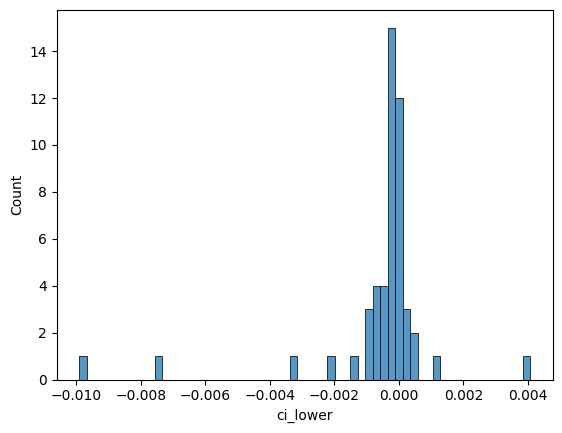

In [ ]:
import seaborn as sns
df_.pipe(sns.histplot, x="ci_lower")